In [1]:
import os
import cv2
import math
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from PIL import Image, ImageDraw, ImageFilter

In [30]:
def get_non_uniform_sampling(source, steps):
    shape = np.shape(source)
    height = shape[0]
    length = shape[1]
    
    x_centre = int(length/2)
    y_centre = int(height/2)
    radius = int(min(length, height)/2)
    
    pi = np.pi
    multiplier = 0.5
    x_coordinates = []
    y_coordinates = []

    for r in steps:
        number_of_points = (1/multiplier) * 2

        for j in range(int(number_of_points)):
            theta = j*pi*multiplier
            x = x_centre + (r * np.cos(theta))
            y = y_centre + (r * np.sin(theta))
            
            if(x<length and x>0 and y<height and y>0):
                x_coordinates.append(int(x))
                y_coordinates.append(int(y))

        multiplier = multiplier/2
    
    return x_coordinates, y_coordinates
    
    return x_coordinates, y_coordinates

def get_roi_values(src, x , y, window_size):
    height = np.shape(src)[0]
    length = np.shape(src)[1]
    
    left = x - int(window_size/2)
    left = max(0, left)
    
    right = x + int(window_size/2)
    right = min(length, right)
    
    top = y - int(window_size/2)
    top = max(0, top)
    
    bottom = y + int(window_size/2)
    bottom = min(height, bottom)
    
    slice_arr = src[top:bottom, left:right]
    
    return slice_arr, np.mean(slice_arr), np.std(slice_arr)

def get_mean_std(src, x_coordinates, y_coordinates, window_size):
    mean = []
    std = []
    number_of_points = np.shape(x_coordinates)[0]
    
    for i in range(number_of_points):
        slice_arr, slice_mean, slice_std = get_roi_values(src, x_coordinates[i], y_coordinates[i], window_size)
        mean.append(slice_mean)
        std.append(slice_std)
    
    return mean, std

def sort_counterclockwise(points, centre = None):
    if centre:
        centre_x, centre_y = centre
    else:
        centre_x, centre_y = sum([x for x,_ in points])/len(points), sum([y for _,y in points])/len(points)
    angles = [math.atan2(y - centre_y, x - centre_x) for x,y in points]
    counterclockwise_indices = sorted(range(len(points)), key=lambda i: angles[i])
    counterclockwise_points = [points[i] for i in counterclockwise_indices]
    return counterclockwise_points

def get_non_uniform_sampling_final(img, number_of_steps):
    shape = np.shape(img)
    height = shape[0]
    length = shape[1]
    radius = int(min(length, height)/2)
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, 2, 255, cv2.THRESH_BINARY)
    blurred = cv2.GaussianBlur(thresh, (3, 3), 0)
    edged = cv2.Canny(blurred, 10, 100)
    arr_edge = np.where(edged==255)
    x_edge = arr_edge[1]
    y_edge = arr_edge[0]
    
    steps = np.linspace(0, radius, number_of_steps)

    for i in range(number_of_steps):
        steps[i] = steps[i] - int(math.pow(i, 3)) + int(math.pow(i, 1.5))

    steps = np.array(steps, dtype=int)
    
    x_coordinates, y_coordinates = get_non_uniform_sampling(img, steps)
    points = []
    for i , j in zip(x_edge, y_edge):
        points.append((i,j))
        
    sorted_points = sort_counterclockwise(points)
    t = np.transpose(sorted_points)
    x_edge = t[0]
    y_edge = t[1]

    interval = 2**(number_of_steps + 1)

    x_edge = np.array(x_edge[0::interval] ,dtype=int)
    y_edge = np.array(y_edge[0::interval], dtype=int)
    
    x_coordinates = np.concatenate([x_coordinates, x_edge])
    y_coordinates = np.concatenate([y_coordinates, y_edge])
    
    return x_coordinates, y_coordinates

def enhance_image(img, image_window_size, background_window_size, threshold):
    (B,G,R) = cv2.split(img)
    height = np.shape(G)[0]
    length = np.shape(G)[1]
    
    # Non Uniform Sampling --------------------------------------------------------------------------------------
    x_coordinates, y_coordinates = get_non_uniform_sampling_final(img, 5)
    
    # Extrapolated mean and standard deviation ------------------------------------------------------------------
    mean, std = get_mean_std(G, x_coordinates, y_coordinates, image_window_size)
    
    xi = np.arange(0, length, 1)
    yi = np.arange(0, height, 1)
    x_grid, y_grid = np.meshgrid(xi, yi)

    points = []
    for i , j in zip(x_coordinates, y_coordinates):
        points.append([i,j])
    
    interpolated_mean = scipy.interpolate.griddata(points, mean, (x_grid, y_grid), method='linear', fill_value=0, rescale=False)
    interpolated_std = scipy.interpolate.griddata(points, std, (x_grid, y_grid), method='linear', fill_value=0, rescale=False)
    
    # Mahalanobis Distance---------------------------------------------------------------------------------------
    mahalanobis = np.empty(np.shape(G))
    background = np.zeros(np.shape(G))
    G = np.array(G)
    
    interpolated_mean = np.array(interpolated_mean)
    interpolated_std = np.array(interpolated_std)
    mahalanobis = np.abs((G - interpolated_mean)/interpolated_std)
    
    indexes = np.where(mahalanobis <= threshold)
    background = np.zeros([height, length], dtype=int)
    background[indexes] = 1
    mult = background*G
    
    # Background operations---------------------------------------------------------------------------------------
    mean_mult = []
    std_mult = []

    for i in range(length):
        for j in range(height):
            mult_slice, temp_mean, temp_std = get_roi_values(mult, i , j, background_window_size)
            mult_slice = mult_slice[(mult_slice != 0)]
            if(not np.any(mult_slice)):
                mean_mult.append(0) 
                std_mult.append(0)
            else:
                mean_m = np.mean(mult_slice)
                std_m = np.std(mult_slice)
                mean_mult.append(mean_m)
                std_mult.append(std_m)
    
    U = np.empty(np.shape(G))
    SM = np.array(mean_mult)
    SA = np.array(std_mult)
    SM = SM.reshape(height, length,  order='F')
    SA = SA.reshape(height, length, order='F')
    U = (G - SM) / SA
    
    U[np.isnan(U)] = 0
    U[~np.isfinite(U)] = 0
    U_norm = (U - np.min(U))/(np.max(U)- np.min(U))
    
    # Final Processing ------------------------------------------------------------------------------------------
    v = np.empty(np.shape(G))
    R = np.array(R)
    G = np.array(G)
    B = np.array(B)

    v = np.maximum(np.maximum(R,G),B)
    R_corr = (U_norm/v)*R
    G_corr = (U_norm/v)*G
    B_corr = (U_norm/v)*B

    R_corr[np.isnan(R_corr)] = 0
    G_corr[np.isnan(G_corr)] = 0
    B_corr[np.isnan(B_corr)] = 0
    
    enhanced_image = cv2.merge([B_corr, G_corr, R_corr])

    return enhanced_image

def write_image(path, img):
    # img = img*(2**16-1)
    # img = img.astype(np.uint16)
    # img = img.astype(np.uint8)
    img = cv2.convertScaleAbs(img, alpha=(255.0))
    cv2.imwrite(path, img)
    
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

def pad_image(image, new_size):
    # Get the size of the original image
    height, width, _ = image.shape

    # Calculate the new size of the padded image
    new_height, new_width = new_size

    # Calculate the padding sizes
    left_pad = (new_width - width) // 2
    right_pad = new_width - width - left_pad
    top_pad = (new_height - height) // 2
    bottom_pad = new_height - height - top_pad

    # Paste the original image in the center of the padded image
    BLACK = [0, 0, 0]
    padded_image = cv2.copyMakeBorder(image, top_pad, bottom_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=BLACK)

    # Save the padded image as a new file
#     padded_image = cv2.convertScaleAbs(padded_image, alpha=(255.0))
    
    return padded_image

In [3]:
folder = "./Images/"
images = load_images_from_folder(folder)
image_names = os.listdir(folder)
n = np.shape(images)[0]
print(n)

63


In [4]:
# img = cv2.imread("./Images/OS0049EY.JPG")
# img[1200:1248, 0:100, :] = 0

# (B,G,R) = cv2.split(img)

# print("Image Dimensions -", np.shape(img))
# cv2.imshow("Source Image", G)
# cv2.waitKey(0)

In [5]:
enhanced_images = []
for i in range(n):
    print("Image", i+1)
    
#     crop_kmc = images[i][5:1254, 100:1555]
#     resized_kmc = cv2.resize(crop_kmc, (450, 380))
#     padded_avr = pad_image(resized_kmc, (512,512))
    
    a = enhance_image(images[i], image_window_size=50, background_window_size=90, threshold=1)
    enhanced_images.append(a)
    name = "./Processed Images/" + image_names[i] + ".png"
    write_image(name, enhanced_images[i])

Image 1


C:\Users\aniru\AppData\Local\Temp/ipykernel_2844/2236792386.py:145: RuntimeWarning: divide by zero encountered in true_divide
  mahalanobis = np.abs((G - interpolated_mean)/interpolated_std)
C:\Users\aniru\AppData\Local\Temp/ipykernel_2844/2236792386.py:145: RuntimeWarning: invalid value encountered in true_divide
  mahalanobis = np.abs((G - interpolated_mean)/interpolated_std)
C:\Users\aniru\AppData\Local\Temp/ipykernel_2844/2236792386.py:174: RuntimeWarning: divide by zero encountered in true_divide
  U = (G - SM) / SA
C:\Users\aniru\AppData\Local\Temp/ipykernel_2844/2236792386.py:174: RuntimeWarning: invalid value encountered in true_divide
  U = (G - SM) / SA
C:\Users\aniru\AppData\Local\Temp/ipykernel_2844/2236792386.py:187: RuntimeWarning: divide by zero encountered in true_divide
  R_corr = (U_norm/v)*R
C:\Users\aniru\AppData\Local\Temp/ipykernel_2844/2236792386.py:187: RuntimeWarning: invalid value encountered in multiply
  R_corr = (U_norm/v)*R
C:\Users\aniru\AppData\Local\Tem

Image 2
Image 3
Image 4
Image 5
Image 6
Image 7
Image 8
Image 9
Image 10
Image 11
Image 12
Image 13
Image 14
Image 15
Image 16
Image 17
Image 18
Image 19
Image 20
Image 21
Image 22
Image 23
Image 24
Image 25
Image 26
Image 27
Image 28
Image 29
Image 30
Image 31
Image 32
Image 33
Image 34
Image 35
Image 36
Image 37
Image 38
Image 39
Image 40
Image 41
Image 42
Image 43
Image 44
Image 45
Image 46
Image 47
Image 48
Image 49
Image 50
Image 51
Image 52
Image 53
Image 54
Image 55
Image 56
Image 57
Image 58
Image 59
Image 60
Image 61
Image 62
Image 63


In [10]:
folder = "C:/College/Coursework/Semester 8/EC498 - Major Project/Repository/Code/Processed Images/KMC/"
processed_images = load_images_from_folder(folder)
image_names = os.listdir(folder)
n = np.shape(processed_images)[0]
print(n)

63


Image 1
Image 2
Image 3
Image 4
Image 5
Image 6
Image 7
Image 8
Image 9
Image 10
Image 11
Image 12
Image 13
Image 14
Image 15
Image 16
Image 17
Image 18
Image 19
Image 20
Image 21
Image 22
Image 23
Image 24
Image 25
Image 26
Image 27
Image 28
Image 29
Image 30
Image 31
Image 32
Image 33
Image 34
Image 35
Image 36
Image 37
Image 38
Image 39
Image 40
Image 41
Image 42
Image 43
Image 44
Image 45
Image 46
Image 47
Image 48
Image 49
Image 50
Image 51
Image 52
Image 53
Image 54
Image 55
Image 56
Image 57
Image 58
Image 59
Image 60
Image 61
Image 62
Image 63


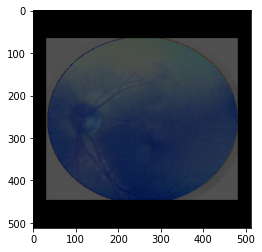

In [29]:
for i in range(n):
    print("Image", i+1)
    #plt.imshow(processed_images[i])
    
    crop_kmc = processed_images[i][5:1254, 100:1555]
    #plt.imshow(crop_kmc)
    
    resized_kmc = cv2.resize(crop_kmc, (450, 380))
    #plt.imshow(resized_kmc)
    
    padded_avr = pad_image(resized_kmc, (512,512))
    plt.imshow(padded_avr)
    name = 'C:/College/Coursework/Semester 8/EC498 - Major Project/Repository/Code/Processed Images/KMC/Cropped' + image_names[i] + '.png'
    write_image(name, padded_avr)

In [6]:
# for i in range(n):
#     name = "./Processed Images/KMCTest" + str(i) + ".png"
#     write_image(name, enhanced_images[i])

In [7]:
# a = enhance_image(images[2], image_window_size=50, background_window_size=90, threshold=1)

# cv2.namedWindow('Enhanced Image', cv2.WINDOW_NORMAL)
# cv2.imshow("Enhanced Image", a)
# cv2.waitKey(0)

In [8]:
# threshold_list = np.array([0.8, 1, 1.2])
# enhanced_images = []
# for i in range(3):
#     print("Image", i+1)
#     a = enhance_image(img, image_window_size=50, background_window_size=125, threshold=threshold_list[i])
#     enhanced_images.append(a)

In [9]:
# n = np.shape(enhanced_images)[0]
# for i in range(n):
#     name = "./Processed Images/KMC" + str(threshold_list[i]) + ".png"
#     write_image(name, enhanced_images[i])

In [10]:
# background_window_size_list = np.array([85, 105, 125])
# enhanced_images_background_window = []
# for i in range(3):
#     print("Image", i+1)
#     a = enhance_image(img, image_window_size=50, background_window_size=background_window_size_list[i], threshold=1)
#     enhanced_images_background_window.append(a)

In [11]:
# n = np.shape(enhanced_images_background_window)[0]
# for i in range(n):
#     name = "./Processed Images/KMC" + str(background_window_size_list[i]) + ".png"
#     write_image(name, enhanced_images_background_window[i])

In [12]:
# x_coordinates, y_coordinates = get_non_uniform_sampling_final(img, 7)
# number_of_points = (np.shape(x_coordinates))[0]
# print("The number of points is", number_of_points)

In [13]:
# img[1200:1248, 0:100, :] = 0

In [14]:
# plt.figure(figsize = (8,8))
# plt.imshow(G)
# plt.scatter(x_coordinates, y_coordinates, color='red')
# plt.colorbar()
# plt.title("Image and Sampling Points")

In [15]:
# mean, std = get_mean_std(G, x_coordinates, y_coordinates, 50)

In [16]:
# xi = np.arange(0, np.shape(G)[1], 1)
# yi = np.arange(0, np.shape(G)[0], 1)
# x_grid, y_grid = np.meshgrid(xi, yi)

# points = []
# for i , j in zip(x_coordinates, y_coordinates):
#     points.append([i,j])

In [17]:
# interpolated_mean = scipy.interpolate.griddata(points, mean, (x_grid, y_grid), method='linear', fill_value=0, rescale=False)

# plt.figure(figsize = (8,8))
# plt.imshow(interpolated_mean)
# plt.colorbar()
# plt.title("Interpolated Mean")

In [18]:
# interpolated_std = scipy.interpolate.griddata(points, std, (x_grid, y_grid), method='linear', fill_value=0, rescale=False)

# plt.figure(figsize = (8,8))
# plt.imshow(interpolated_std)
# plt.colorbar()
# plt.title("Interpolated Standard Deviation")

In [19]:
# height = np.shape(G)[0]
# length = np.shape(G)[1]

# mahalanobis = np.empty(np.shape(G))
# background = np.zeros(np.shape(G))

# G = np.array(G)
# interpolated_mean = np.array(interpolated_mean)
# interpolated_std = np.array(interpolated_std)

# mahalanobis = np.abs((G - interpolated_mean)/interpolated_std)
# plt.figure(figsize = (8,8))
# plt.imshow(mahalanobis, cmap='binary')
# plt.colorbar()
# plt.title("Mahalanobis Distance")

In [20]:
# threshold = 1
# indexes = np.where(mahalanobis <= threshold)
# background = np.zeros([height, length], dtype=int)
# background[indexes] = 1

# plt.figure(figsize = (8,8))
# plt.imshow(background, cmap="binary_r")
# plt.colorbar()
# plt.title("Background")

In [21]:
# background = np.array(background)
# G = np.array(G)
# mult = background*G

# mult = mult.astype(np.uint8)
# plt.figure(figsize = (8,8))
# plt.imshow(mult)
# plt.colorbar()
# plt.title("Mult")

In [22]:
# mean_mult = []
# std_mult = []
# background_window_size = 125
  
# for i in range(length):
#     for j in range(height):
#         mult_slice, temp_mean, temp_std = get_roi_values(mult, i , j, background_window_size)
#         mult_slice = mult_slice[(mult_slice != 0)]
#         if(not np.any(mult_slice)):
#             mean_mult.append(0) 
#             std_mult.append(0)
#         else:
#             mean_m = np.mean(mult_slice)
#             std_m = np.std(mult_slice)
#             mean_mult.append(mean_m)
#             std_mult.append(std_m)

In [23]:
# U = np.empty(np.shape(G))
# SM = np.array(mean_mult)
# SA = np.array(std_mult)
# SM = SM.reshape(height, length,  order='F')
# SA = SA.reshape(height, length, order='F')
# U = (G - SM) / SA

In [24]:
# U[np.isnan(U)] = 0
# U[~np.isfinite(U)] = 0
# U_norm = (U - np.min(U))/(np.max(U)- np.min(U))

# plt.figure(figsize = (8,8))
# plt.imshow(U_norm)
# plt.colorbar()
# plt.title("U norm")

In [25]:
# plt.figure(figsize = (8,8))
# plt.imshow(SA)
# plt.colorbar()
# plt.title("SA")

# plt.figure(figsize = (8,8))
# plt.imshow(SM)
# plt.colorbar()
# plt.title("SM")

In [26]:
# v = np.empty(np.shape(G))
# R = np.array(R)
# G = np.array(G)
# B = np.array(B)

# v = np.maximum(np.maximum(R,G),B)
# R_corr = (U_norm/v)*R
# G_corr = (U_norm/v)*G
# B_corr = (U_norm/v)*B

# R_corr[np.isnan(R_corr)] = 0
# G_corr[np.isnan(G_corr)] = 0
# B_corr[np.isnan(B_corr)] = 0

# plt.figure(figsize = (8,8))
# plt.imshow(R_corr)
# plt.colorbar()
# plt.title("Corrected R plane")

# plt.figure(figsize = (8,8))
# plt.imshow(G_corr)
# plt.colorbar()
# plt.title("Corrected G plane")

# plt.figure(figsize = (8,8))
# plt.imshow(B_corr)
# plt.colorbar()
# plt.title("Corrected B plane")

In [27]:
# enhanced_image = cv2.merge([B_corr, G_corr, R_corr])

In [28]:
# cv2.namedWindow('Enhanced Image', cv2.WINDOW_NORMAL)
# cv2.imshow("Enhanced Image", enhanced_image)
# cv2.waitKey(0)